## P4DS: Assignment 3 (Autumn 2020)

# Data Analysis Project

#### Notebook template design: Brandon Bennett (2020/11/3)

# _Network Visualization of Most Influential and Popular Artists_


### Project participants:

* A. Bhumit Adivarekar (sc20bva@leeds.ac.uk)
* B. Hiresh Joshi (sc20hdj@leeds.ac.uk)
* C. Bashaer Almashy (ml20bma@leeds.ac.uk)

# Project Plan

## The Data (10 marks)

The dataset consists of song tracks and its features, available on Spotify from 1922 to April 2021. The dataset is downloaded from [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks). The data is collected using official Spotify Web API (updated on 20th April 2021). The latest dataset contains three files along with some old files as follows.

#### New Files
* _tracks.csv (audio features of tracks, 600k rows)._
* _artists.csv (popularity metrics of artists, 1.1M rows)._
* _dict_artists.json (artists related artists, represented by ids)._

__dict_artists.json__ can be derived from tracks.csv.

#### Old Files
* _data_o.csv (audio features of tracks, original data, 170k rows)_
* _data_by_artist_o.csv (audio features of artists, derived from data_o.csv, 30k rows)_
* _data_by_year_o.csv (audio features of years, derived from data_o.csv, 100 rows)_
* _data_by_genres_o.csv (audio features of genres, derived from databyartist_o.csv, 3k rows)_


We are going to use __tracks.csv__ file for our project as it contains more features and more number of rows.

#### Column Description

* __id__: The Spotify ID for the track.
* __name__: Name of the song track.
* __popularity__: The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity is calculated by an algorithm and is based on the total number of plays the track has had and how recent those plays are.
* __duration_ms__: Duration of track in milliseconds.
* __explicit__: Track containing explicit language. 1 means song contains explicit language while 0 means it does not.
* __artists__: Artist(s) who contributed to the track.
* __id_artists__ : Artist(s) Unique Spotify ID.
* __release_date__ : Date of release of the track. Could be proper date in "DD/MM/YYYY" format or only year "YYYY".
* __danceability__: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
* __energy__: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
* __key__: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation.
* __loudness__: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
* __mode__: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
* __speechiness__: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
* __acoustiness__: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* __instrumentalness__: Represents whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.
* __liveness__: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
* __valence__: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
* __tempo__: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
* __time_signature__: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).


## Project Aim and Objectives (5 marks)

### Aim

Querying most influencial artists, based on collaborations with other artists, popularity of solo and collab songs and visualizing them as a network graph.


### Specific Objective(s)

* __Objective 1:__ _Preprocessing Data to build a Graph_
* __Objective 2:__ _Find most influential/popular artists._
* __Objective 3:__ _Visualise network of most influential/popular artists._

## System Design (5 marks)

### Architecture

The system architecture is pretty straight forward

<img src="Network-Visualization-Workflow.png">

### Processing Modules and Algorithms

* We will start by loading the dataset and keeping only necessary columns like __artists__ and __popularity__.
* In the second step, we will only keep songs who have multiple artists.
* In third step, we clean the names of artists by simple string operations.
* After this, we need to represent this data as a Graph with artist name as __nodes__ and their collaboration as __edges__ as popularity as __weight__ of the __edge__.
* After building a Graph, we need to find the artists (nodes) with most connections. So we will create a dictionary of nodes which contains count of their neighbours. After that we sort it in descending order and save it as a list.
* We visualize top artists as a network graph. We only visualize top artists because visualizing is computationally intensive and visualizing alot the whole graph might take away the charm of the plot.


# Program Code (15 marks)

To run the following code, few packages are required.<br>
Uncomment and run the following cell to install packages

In [86]:
## Important python packages/modules. Uncomment and run these to install necessary packages.

# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install networkx
# !pip install bokeh

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ast
import networkx as nx
from bokeh.io import output_notebook, show, save, curdoc
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap

output_notebook()

Loading BokehJS ...

# Network Type 1: Collaborations with other Artists

## Objective 1

#### Helper functions for cleaning and preprocessing

In [88]:
def select_multiple_artists(data):
    '''
        Most songs are by solo artists, but in our case we want collaborated songs
    '''
    collabs = []
    indexs = []
    for i, row in data.iterrows():
        if len(row['artists'].split(',')) > 1:
            indexs.append(i)
            collabs.append(row['artists'])
    
    return indexs, collabs

def clean_data(data):
    '''
        Data given is bit messy so cleaning to get proper names
    '''
    cleaned = []
    for value in data:
        new_vals = []
        for name in value.split(','):
            processed = name.replace('[', '').replace(']', '').replace("'", '').strip()
            new_vals.append(processed)
        cleaned.append(new_vals)
    return cleaned

def unique_names(data):
    '''
        We need to extract unique names to create nodes in the graph
    '''
    unique_list = []
    for i in data:
        unique_list.extend(i)
    unique_list = list(set(unique_list))
    return unique_list

def collaborations(data):
    '''
        If more than two collaborators for a song, we need to club the artists in group of two to connect edge.
    '''
    collab = []
    for i in data:
        for j in range(1, len(i)):
            temp = []
            temp.append([i[0], i[j]])
            collab.append(temp)
    return collab

def find_neighbours(graph, nodes):
    '''
        This method returns a dictionary of nodes and their neighbour counts.
    '''
    neighbour_cnt = {}
    for node in nodes:
        try:
            neighbour_cnt[node] = len([n for n in G.neighbors(node)])
        except:
            print(node)
    return neighbour_cnt

#### Loading Data

We will load __tracks.csv__ from filesystem and carryout the next steps

In [89]:
tracks_df = pd.read_csv('./Datasets/Spotify Dataset 1921-2020, 600k+ Tracks/tracks.csv')
tracks_df.sample(5)

id                    name  popularity  \
523100  3AToepT304JdBOsCyTcq3m          College Age Lo          22   
57673   2WDvW3o8WeGN4v4cpsYVhT  Slippery People - Live          56   
276040  73QKrC6u5qNEQLZgF87gwk                  最後的茱麗葉          25   
446085  3VEOqYqWTx2tdxE8dIIBmA      Duka Sang Bahaduri          10   
295420  4UqN9DAUKlN5NwwRnTNWGD                   Avaro          32   

        duration_ms  explicit                                    artists  \
523100       245395         0  ['S. P. Balasubrahmanyam', 'P. Susheela']   
57673        240960         0                          ['Talking Heads']   
276040       258913         0                              ['Joey Yung']   
446085       269733         0                                ['Chrisye']   
295420       150375         1                  ['Slogan', 'Evan Spikes']   

                                               id_artists release_date  \
523100  ['2ae6PxICSOZHvjqiCcgon8', '0aFGod7DM6b3O5l1Am...   1989-02-20   
57673                          ['2x9SpqnPi8rlE9pjHBwmSC']         1984   
276040                         ['2zzKlxMsKTPMsZacZCPRNA']   2007-01-14   
446085                         ['2NteKKMj3takKR3ABTd279']   1978-05-10   
295420  ['64Eb4jttIVIP6T2qVBP8wh', '6p5qNRLXkVrmKVRPMa...   2019-08-02   

        danceability  energy  key  loudness  mode  speechiness  acousticness  \
523100         0.343   0.772   10    -9.398     1       0.0540       0.31000   
57673          0.637   0.851    9    -8.127     0       0.0437       0.21600   
276040         0.455   0.836    8    -4.175     1       0.0636       0.20800   
446085         0.227   0.458    2    -7.344     0       0.0331       0.89500   
295420         0.720   0.792    5    -7.808     0       0.0707       0.00153   

        instrumentalness  liveness  valence    tempo  time_signature  
523100          0.000000     0.337   0.9610  194.090               3  
57673           0.036500     0.680   0.8400  110.892               4  
276040          0.000000     0.104   0.3170  145.699               4  
446085          0.462000     0.206   0.0589  127.644               4  
295420          0.000261     0.104   0.6770   75.012               4

As seen in the above dataframe output, artist column have some single artist and some have multiple artist. In first network we are interested in multiple artists. We will do preprocessing in further steps. 

#### Keeping Specific Columns

We don't need all the columns for our task, for this first network type we just need __artist__ column.

In [90]:
artists = tracks_df[['artists']]

#### Selecting tracks with multiple artists

As discussed in above cells, for our network-1, we need only collaborators.

In [91]:
collabs_df_idx, collabs_data = select_multiple_artists(artists)
display(collabs_data[:5])

["['Dick Haymes', 'Gordon Jenkins', 'His Orchestra']",
 "['Dick Haymes', 'Harry James', 'His Orchestra']",
 "['Dick Haymes', 'Harry James', 'His Orchestra']",
 "['Dick Haymes', 'Victor Young', 'His Orchestra']",
 "['Dick Haymes', 'The Pied Pipers']"]

Notice the output contains only data with multiple artists. But it doesn't looks neat, we will do some preprocessing to 
clean it up.

#### Cleaning Artists Names

In [92]:
cleaned_data = clean_data(collabs_data)
display(cleaned_data[:5])

[['Dick Haymes', 'Gordon Jenkins', 'His Orchestra'],
 ['Dick Haymes', 'Harry James', 'His Orchestra'],
 ['Dick Haymes', 'Harry James', 'His Orchestra'],
 ['Dick Haymes', 'Victor Young', 'His Orchestra'],
 ['Dick Haymes', 'The Pied Pipers']]

Now its look clean and they are converted to nested lists.

#### Creating Graph

__Steps__
* First, we will get unique artists.
* Initialize graph and create nodes based on the unique artist name.
* Creating edges between nodes.
* Adding edges to the graph
* Saving the Graph as a Dataframe

In [93]:
# Getting unique artists
nodes = unique_names(cleaned_data)

# Initializing graph and creating nodes
G = nx.Graph()

for node in nodes:
    G.add_node(node)

# Creating edges between nodes
edges = collaborations(cleaned_data)

# Adding edges(collabs) around nodes(artists) on the graph
for edge in edges:
    edge = edge[0]
    G.add_edge(edge[0], edge[1])

# Saving graph as dataframe
df = nx.to_pandas_edgelist(G, 'Artist1', 'Artist2')

df.head()

Artist1                                      Artist2
0                                           Not Applicable
1              Pal. Jurgio Matulaicio misijos vaiku choras
2                                             Lagrima Rios
3  Sahu Modak                                      Vanmala
4  Sahu Modak                           Snehprabha Pradhan

As you can see the first three rows have __white spaces__ in __Artist1__ column. We can drop them

#### Dropping unnecessary rows

There are some value like "N/A", which the dataframe is considering as NaN's, so we will replace them with "No Artist"

In [94]:
df.drop([0,1,2], axis=0, inplace=True)

df = df.fillna('No Artist')

df.sample(5)

Artist1        Artist2
66017  Erich Wolfgang Korngold    Nello Santi
246               Trio Surdina   Léo Peracchi
49681         Diamond Platnumz       Rayvanny
43980        Michael Köhlmeier     Armin Egle
7169              Lycoriscoris  Grandbrothers

We have our graph in dataframe format as well. We can use both for further analysis.

## Objective 2

#### Find Most influential artist

We will find out which artist have collaborated more with other artists.<br>
Then we will sort them in descending order.

In [95]:
artist_influence = find_neighbours(G, nodes)

sorted_artist_influence = sorted(artist_influence.items(), key=lambda x: x[1], reverse=True)

print('Top 10 Influential Artist.\n', sorted_artist_influence[:10])

Top 10 Influential Artist.
 [('Wolfgang Amadeus Mozart', 743), ('Johann Sebastian Bach', 434), ('Giuseppe Verdi', 429), ('Ludwig van Beethoven', 364), ('Giacomo Puccini', 251), ('Richard Wagner', 187), ('Franz Schubert', 170), ('George Frideric Handel', 166), ('Richard Strauss', 163), ('Leonard Bernstein', 158)]


The output is form of tuple, where first element is artist name and second element is number of collaborations.

## Objective 3

### Visualizing Network

In [96]:
curdoc().theme = 'dark_minimal'
top_k = 5
top_neighbours = sorted_artist_influence[:top_k]

ndf = pd.DataFrame(data=[], columns=['Artist1', 'Artist2'])

top_influencers_name = {n[0]:(top_k-i)*2 for i,n in enumerate(top_neighbours)}

for node in top_neighbours:
    
    ndf = ndf.append(df[(df['Artist1'] == node[0]) | (df['Artist2'] == node[0])])

ndf = ndf.drop_duplicates()

G = nx.from_pandas_edgelist(ndf, 'Artist1', 'Artist2')

degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

number_to_adjust_by = 5
adjusted_node_size = dict([(node, min(degree+number_to_adjust_by, 17)) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

title = f'Top {top_k} Artists Collaborations'

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Spectral8

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Artist", "@index"), ('Collabs', '@degree')]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,box_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=(-10.5, 10.5), y_range=(-10.5, 10.5), title=title, plot_width=900)

network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))
# network_graph = from_networkx(G, nx.random_layout, center=(0, 0))

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set node size and color
# network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1, line_color='orange')

#Add network graph to the plot
plot.renderers.append(network_graph)

###Add Labels Uncomment this for getting labels but looks messy
x, y = zip(*network_graph.layout_provider.graph_layout.values())
node_labels = list(G.nodes())
source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] if node_labels[i] in top_influencers_name.keys() else '' for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
plot.renderers.append(labels)

show(plot)
# save(plot, filename=f'./analysis/Top_{top_k}_collaborators.html')

In [97]:
print(f'Top {top_k} Collaborators.\n')
display(sorted_artist_influence[:20])

Top 5 Collaborators.



[('Wolfgang Amadeus Mozart', 743),
 ('Johann Sebastian Bach', 434),
 ('Giuseppe Verdi', 429),
 ('Ludwig van Beethoven', 364),
 ('Giacomo Puccini', 251),
 ('Richard Wagner', 187),
 ('Franz Schubert', 170),
 ('George Frideric Handel', 166),
 ('Richard Strauss', 163),
 ('Leonard Bernstein', 158),
 ('A.R. Rahman', 157),
 ('Antonio Vivaldi', 154),
 ('Pyotr Ilyich Tchaikovsky', 152),
 ('Johannes Brahms', 151),
 ('Traditional', 138),
 ('Pritam', 136),
 ('Armin van Buuren', 135),
 ('Lata Mangeshkar', 132),
 ('Georges Bizet', 130),
 ('Claude Debussy', 128)]

The above network plot depicts the network graph of top 5 collaborators. Out of which __Wolfgang Amadeus Mozart__ is most infleuntial collaborator.

# Network Type 2: Popularity of Solo and Collab songs

The previous network type 1 only consists of collaborations. But what if an artist has many popular solo songs, which can be considered as influential. Here this network type 2 will also have self-connected nodes, where the edge of this node contains the popularity scores of all songs of that artist.

#### Note

Since, the steps are similar to above network type 1. We will run most of the code in single cells to ease.

__Explaination will be provided where needed.__

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ast
import networkx as nx
from bokeh.io import output_notebook, show, save, curdoc
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap

output_notebook()

Loading BokehJS ...

#### Helper functions for preprocessing and creating graph

In [99]:
def artists_popularity(data):
    '''
        We want songs artist and popularity
    '''
    collabs = []
    indexs = []
    for i, row in data.iterrows():
        if len(row['artists'].split(',')) >= 1:
            indexs.append(i)
            collabs.append([row['artists'],row['popularity']])
    
    return indexs, collabs

def clean_data(data):
    '''
        Data given is bit messy so cleaning to get proper names
    '''
    cleaned = []
    for value in data:
        new_vals = []
        for name in value[0].split(','):
            processed = name.replace('[', '').replace(']', '').replace("'", '').strip()
            new_vals.append(processed)
        cleaned.append([new_vals, value[1]])
    return cleaned

def unique_names(data):
    '''
        We need to extract unique names to create nodes in the graph
    '''
    unique_list = []
    for i in data:
        unique_list.extend(i[0])
    unique_list = list(set(unique_list))
    return unique_list

def collaborations(data):
    '''
        If more than two collaborators for a song, we need to club the artists in group of two to connect edge.
        Returns list of [edges, weight]
    '''
    collab = []
    for i in data:
        for j in range(1, len(i)):
            temp = []
            temp.append([i[0][0], i[0][j]])
        collab.append([temp, i[1]])
    return collab

def split_collab_solo(data):
    '''
        We will split cleaned data into solo and collab lists based on number of artists.
    '''
    solo = []
    collab = []
    for artists in data:
        if len(artists[0]) > 1:
            collab.append(artists)
        elif len(artists[0]) == 1:
            solo.append(artists)
    return solo, collab

def solo_popularity(solo):
    '''
        Calculate solo artist popularity and return dictionary
    '''
    solo_artist_pop = {}

    for artist in solo:
        pop = artist[1]
        singer = artist[0][0]
        if singer not in solo_artist_pop.keys():
            solo_artist_pop[singer] = pop
        else:
            solo_artist_pop[singer] += pop
    
    return solo_artist_pop

def calculate_artist_influence(graph, nodes):
    '''
        Calculated Artists influence, in this case we will use sum of weights(popularity).
    '''
    node_influence = {}
    exceptions = []
    for node in nodes:
        try:
            node_influence[node] = sum([G.get_edge_data(node, n)['weight'] for n in G.neighbors(node)])
        except Exception as e:
            print(e)
            exceptions.append(node)
    #print(len(exceptions))
    return node_influence

def replace_none_by_min(data, min_val=10):
    '''
        If None values present in a list.
        Returns a list without None values by replacing it with min_val.
    '''
    final_data = []
    for val in data:
        if val != None:
            final_data.append(val)
        else:
            final_data.append(min_val)
    return final_data

### Loading, Preprocessing, Cleaning before generating Graph

In [100]:
# Loading dataset
tracks_df = pd.read_csv('./Datasets/Spotify Dataset 1921-2020, 600k+ Tracks/tracks.csv')
popular_artists = tracks_df[['artists', 'popularity']]

# Preprocessing and cleaning
idx, artists = artists_popularity(popular_artists)

cleaned_artists = clean_data(artists)

node_names = unique_names(cleaned_artists)

# splitting into solo and collab projects
solo, collab = split_collab_solo(cleaned_artists)

# Calculating solo artist popularity
solo_artist_popularity = solo_popularity(solo)

# Collab edges
collab_edges = collaborations(collab)

### Creating Graph

In [101]:
# Create Graphs
G = nx.Graph()

# Adding nodes
for node in node_names:
    G.add_node(node)
    
# Add self-connected node edges first
for edge, pop in solo_artist_popularity.items():
    G.add_edge(edge, edge, weight=pop)
    
# Add collab edges
for edge in collab_edges:
    w = edge[1]
    edge = edge[0][0]
    G.add_edge(edge[0], edge[1], weight = w)

### Calculating Artist popularity

In [102]:
artist_popularity = calculate_artist_influence(G, node_names)

sorted_artist_popularity = sorted(artist_popularity.items(), key=lambda x: x[1], reverse=True)

### Conversion

Converting graph object to dataframe for ease of querying data

In [103]:
df = nx.convert_matrix.to_pandas_edgelist(G)
df.drop([0,1,2,3], axis=0, inplace=True)

As first 4 rows were whitespaces we will drop them.

### Visualizing Network

In [104]:
curdoc().theme = 'dark_minimal'

top_k = 20
top_neighbours = sorted_artist_popularity[:top_k]

top_influencers_name = {n[0]:(top_k-i)*2 for i,n in enumerate(top_neighbours)}

ndf = pd.DataFrame(data=[], columns=['source', 'target', 'weight'])

for node in top_neighbours:
    
    ndf = ndf.append(df[(df['source'] == node[0]) | (df['target'] == node[0])])

ndf = ndf.drop_duplicates()
ndf.reset_index(inplace=True, drop=True)

G = nx.from_pandas_edgelist(ndf, 'source', 'target', 'weight')

# degrees = dict(nx.degree(G))
# nx.set_node_attributes(G, name='degree', values=degrees)

influence = artist_popularity
nx.set_node_attributes(G, name='influence', values=influence)

number_to_adjust_by = 5
adjusted_node_size = dict([(node, top_influencers_name[node] + 15 if node in top_influencers_name.keys() else 10) for node, inf in influence.items()])
# print(len(adjusted_node_size))
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

title = f'Top {top_k} Influencial Artists Solo/Collaborations'

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Spectral8

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Artist", "@index"), ('Popularity', '@influence')]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,box_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=(-10.5, 10.5), y_range=(-10.5, 10.5), title=title, plot_width=900)

network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))
# network_graph = from_networkx(G, nx.random_layout, center=(0, 0))

#Set node sizes and colors according to node degree (color as spectrum of color palette)
# print(len(network_graph.node_renderer.data_source.data[color_by_this_attribute]))
try:
    minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
    maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
except:
    print('Exception occured trying different solution')
    minimum_value_color = min(replace_none_by_min(network_graph.node_renderer.data_source.data[color_by_this_attribute]))
    maximum_value_color = max(replace_none_by_min(network_graph.node_renderer.data_source.data[color_by_this_attribute]))
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set node size and color
# network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1, line_color='orange')

#Add network graph to the plot
plot.renderers.append(network_graph)

###Add Labels Uncomment this for getting labels but looks messy
x, y = zip(*network_graph.layout_provider.graph_layout.values())
node_labels = list(G.nodes())
source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] if node_labels[i] in top_influencers_name.keys() else '' for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
plot.renderers.append(labels)

# save(plot, filename=f'./analysis/Top_{top_k}_popular_solo_and_collab_artists.html')
show(plot)

In [105]:
print(f'Top {top_k} Popular Solo & Collab Artists.\n')
display(top_neighbours)

Top 20 Popular Solo & Collab Artists.



[('Die drei ???', 140705),
 ('TKKG Retro-Archiv', 58554),
 ('Bibi Blocksberg', 50096),
 ('Benjamin Blümchen', 42371),
 ('Bibi und Tina', 32037),
 ('Queen', 29661),
 ('Taylor Swift', 22954),
 ('Fünf Freunde', 22190),
 ('Elvis Presley', 22048),
 ('Pink Floyd', 21787),
 ('The Rolling Stones', 21098),
 ('The Beatles', 20164),
 ('Fleetwood Mac', 18186),
 ('Frank Sinatra', 17841),
 ('Julio Iglesias', 17582),
 ('Metallica', 16747),
 ('BTS', 15952),
 ('Luis Miguel', 15802),
 ('Lata Mangeshkar', 15088),
 ('Bob Dylan', 14797)]

When we include solo artists the picture is quite different. The most influential artist in first network is no where near top 20 in new network. This helps us understand that even without higher number of collaborations, popularity can be gained.

# Project Outcome (10 + 10 marks)

## Overview of Results
For this Data Analysis Project, we made two type of network, Network-1 with only collaboration between artists, Network-2 contains both collaboration between artist and solo song with popularity of the song. It shows that based on the network type, the top artists may differ.<br>
In network-1 we observe that most of the artists are very old composers like __Giacomo Puccini__, __Lata Mangeshkar__, etc. In network-2, where we consider popularity of solo artists as well, old names like __The Beatles__, __Elvis Presley__, __Elvis Presley__ along with new names like __Taylor Swift__, __BTS__, __Metallica__. can be seen. Here both networks conclude that old artist were more ready to collaborate compared to new artists and old bands are still popular till date.<br>
Both networks displays that old artist and songs are still popular in todays time. Network-1 shows that artists in 90s were more likely to collaborate. Network-2 shows that artist are not required to collaborate to get popular.

## Objective 1 - Preprocessing Data to Build Graph

### Explanation of Results

In 1st objective, we carry out most primitive steps i.e. data cleaning, preprocessing and transforming. Here we first keep necessary columns for our analysis, clean the data by removing unnecessary brackets, whitspaces. In preprocessing we extract unique artist names as our nodes and create edges between those nodes representing collaborations. In transformation, we transform this data to a Graph, which helps us to understand connections of the artists and much more.
Finally we convert this Graph data to pandas.DataFrame object for ease of analysis.

### Visualisation
Here we are not visualising anything, this is just preprocessing step.

## Objective 2: Find most influential/popular artists
### Explanation of Results

One of the main purpose of creating Graphs was to find the neighbours of the nodes(artists). Graph is made of nodes and edges, nodes can represent anything, a number, array, vector, hash, image, anything, in our case its a string and edges represents the connection between them.<br>
In network-1, we calculate number of collaborations based on number of neighbours to our node. While in network-2, we calculate popularity based on sum of weights of all the neighbours of that node. We get a dictionary with artists names as key and popularity as value. <br>
After getting these dictionaries we sort them and send them to next objective to visualize the top artists.

### Visualisation
Here we are not visualising anything, this is calculation step before visualisation.

## Objective 3: Visualise network of most influential/popular artists.
### Explanation of Results

After getting the artists in sorted order, we can use them to visualize the results as a network.<br> As business perspective, we can use this to build prediction systems like, if high popular artist is a part of project, then it can be speculated that the song is going to pe popular.<br> Another example could be endorsing some products, people follow popular artists, so if popular artist endorsing have higher influence on people who follow them.<br>
Another area this could be used is for making recommendations, if a user likes to listen to particular artist, then a system could be built which can recommend another artist based on collaborations.

### Visualisation

Text(0.5, 1.0, 'Top 5 Influential Artist')

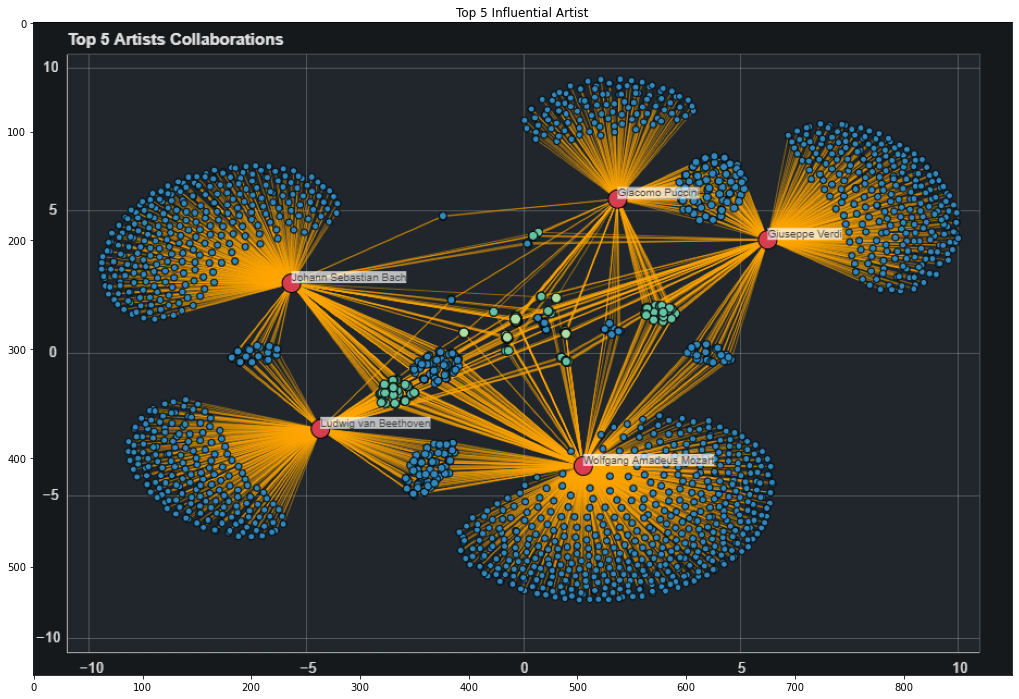

In [82]:
from PIL import Image

img = Image.open('./analysis/top_5_artist_collaborations_n1.png')
plt.figure(figsize=(20,12))
plt.imshow(img)
plt.title('Top 5 Influential Artist')

In the above visualisation we can see that __Wolfgane Amadeus Mozart__ had most collaboration and it makes him most influential artists of all time.

Text(0.5, 1.0, 'Top 20 Popular Solo and Collab Artist')

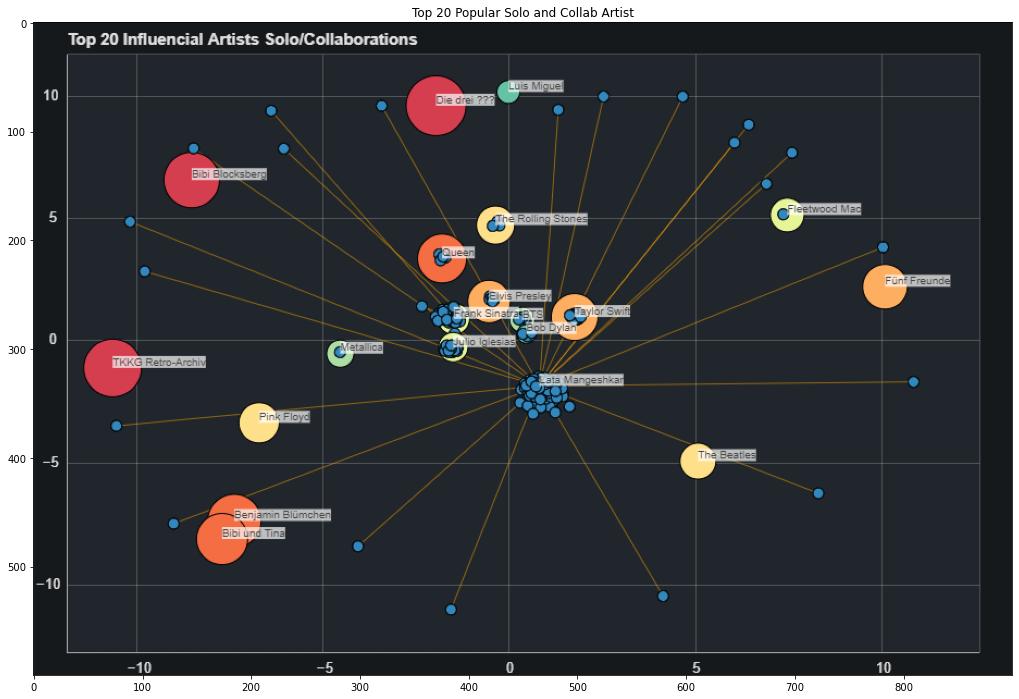

In [84]:
img = Image.open('./analysis/top_20_solo_and_collabs.png')
plt.figure(figsize=(20,12))
plt.imshow(img)
plt.title('Top 20 Popular Solo and Collab Artist')

The above network visualisation depicts that artist __Die Drie ???__ is the most popular artist with no collabs. Most of the popular artists have hardly collaborated on any project other than few like __Frank Sinatra__, __Lata Mangeshkar__ and __Bob Dylan__.

# Conclusion (5 marks)

### Acheivements
We were successfully able to find most influential and popular artists of all time and visualize them. We also expected that artists with more collabs would also be more popular with users, but that hypothesis was not true. The results were surprising showing some artist without hardly any collaboration were way more popular that influential artists with higher collaborations. We also found out that old artists had more collaborations than newer artists. We also found out that old artists like __The Beatles__, __Elvis Presley__ and more are still popular with younger generation.

### Limitations

* Visualisation of networks is highly computing intensive, as the number of nodes increases, it takes more time to generate the graph which also increase the interactive plot file size, which makes it hard to render in browser.
* Unable to visualise whole network, there more than 80k rows, which is highly computing intensive. 

### Future Work

In future work, we would like to use more features like date of release, liveness, and other songs parameters to judge the popularity or influence of the artist. We also like to use these features to create clusters of artists and compare it with our both networks and would like to know that if artists similar or different genres collaborate or not

# Grading

_Feedback and marks will be given here._

### Feedback

### Marks

In [56]:
DATA   = 10
AIMS   =  5
DESIGN = 5

CODE = 15

OUTCOME_EXPLANATION   = 10
OUTCOME_VISUALISATION = 10

CONCLUSION = 5

TOTAL = ( DATA + AIMS + DESIGN + CODE 
          + OUTCOME_VISUALISATION + OUTCOME_VISUALISATION
          + CONCLUSION )
TOTAL

60